# 3D Rendering
* Raster drawing (2D)
* Projecting a point cloud
* Rotations
* Drawing a triangle
* Mesh representation
* left.obj
* (Z-buffering)

What we will not talk about: OpenGL conventions

## Raster drawing

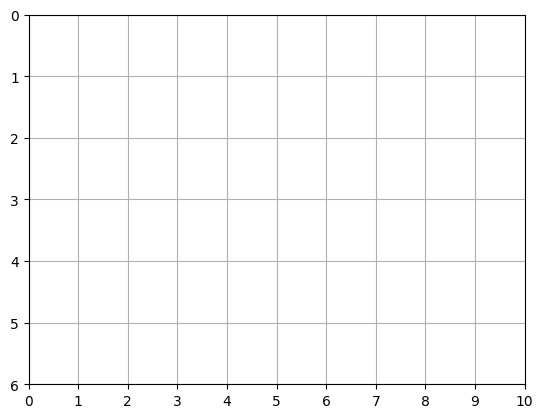

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True)); ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 10])
ax.set_ylim([6, 0])
plt.grid()

In [4]:
import numpy as np
np.set_printoptions(suppress=True)

In [5]:
resolution = 320, 200
w, h = resolution
# Allocate a byte buffer. 0 = black, 255 = white
buffer = np.zeros((h, w, 3), dtype=np.uint8)

In [6]:
n = 512
np.random.seed(17)  # official KTH random number
pixels = 0.5 * np.array(resolution) + np.random.normal(size=(n, 2)) * 24
pixels

array([[166.63038136,  55.48892611],
       [174.97362667, 127.48747095],
       [184.89257124, 145.27933431],
       ...,
       [153.10858755,  79.91050367],
       [152.93358966,  95.34483545],
       [161.90449814,  97.83165585]])

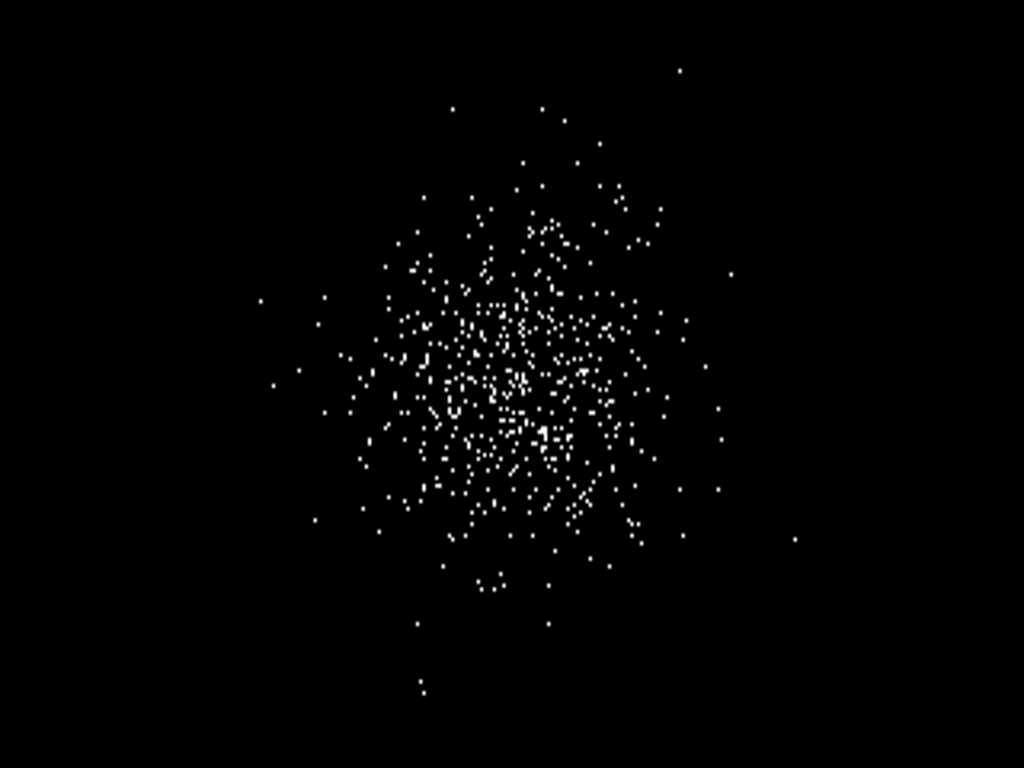

In [7]:
from typing import Tuple
from PIL import Image

def create_buffer(resolution: Tuple[int, int]):
    w, h = resolution
    return np.zeros((h, w, 3), dtype=np.uint8)

def draw_pixels(buffer: np.ndarray, pixels: np.ndarray) -> None:
    assert pixels.shape[1] == 2
    h, w, _ = buffer.shape
    for sx, sy in pixels.astype(int):
        if 0 < sx < w and 0 < sy < h:
            buffer[sy, sx] = 255

def show_buffer(buffer: np.ndarray) -> None:
    return Image.fromarray(buffer).resize((1024, 768))
    
buffer = create_buffer(resolution)
draw_pixels(buffer, pixels)
show_buffer(buffer)

## Projection

In [8]:
vertices = np.random.normal(size=(n, 3))
vertices

array([[ 2.15165278, -0.71095618, -0.6163025 ],
       [-1.99281973, -0.37794909,  0.65329231],
       [-0.57561072,  0.70099174,  1.40039189],
       ...,
       [-0.09967203,  0.54199875,  1.0129728 ],
       [ 2.09024037,  0.47871683, -1.1248412 ],
       [ 1.62813459,  0.76243249, -0.60888518]])

In [9]:
def orthographic(vertices: np.ndarray) -> np.ndarray:
    assert vertices.shape[1] == 3
    # just drop (ignore) z values
    return vertices[:, :2]  # first index means return all rows, :2 means return first two columns (but not the third which is z)

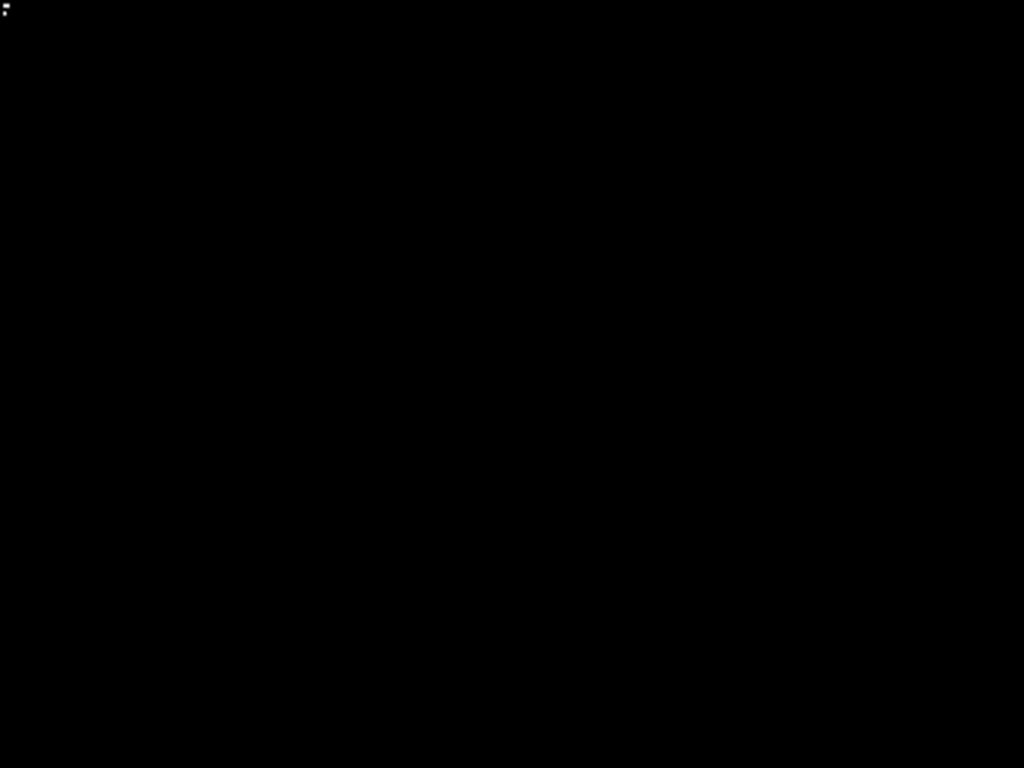

In [10]:
buffer = create_buffer(resolution)
draw_pixels(buffer, orthographic(vertices))
show_buffer(buffer)

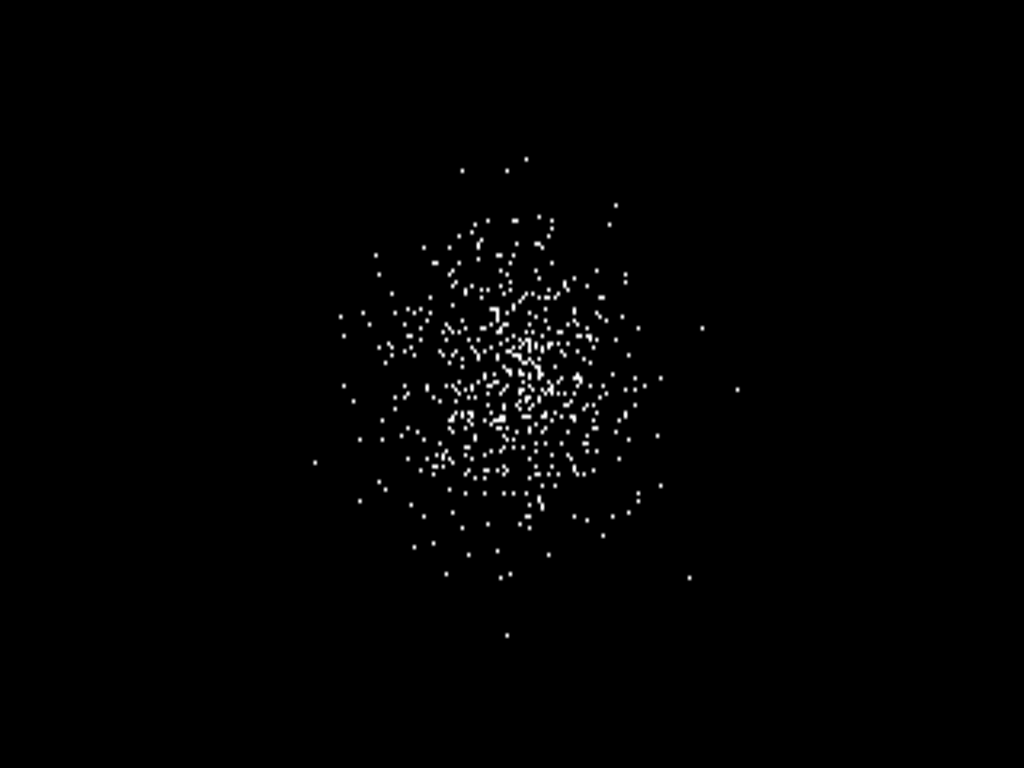

In [11]:
def to_screen(ndc: np.ndarray, resolution: Tuple[int, int]) -> np.ndarray:
    """Transforms pixels from the NDC cordinate system (-1 to 1) to the specificed resolution"""
    scale = np.min(resolution)  # find isotropic scale factor to avoid aspect ratio complications
    return 0.5 * np.array(resolution) + scale * ndc

vertices = np.random.normal(size=(n, 3)) * 0.1  # smaller point cloud so it fits within the resolution
buffer = create_buffer(resolution)
draw_pixels(buffer, to_screen(orthographic(vertices), resolution))
show_buffer(buffer)

### Rotation matrix
$$\mathbf{R}\mathbf{R}^T = \mathbf{R}^T\mathbf{R} = \mathbf{I}$$

In [12]:
from math import pi
tau = 2 * pi  # one revolution (turn)

In [14]:
from math import cos, sin

def rotate_y(theta: float) -> np.ndarray:
    return np.array([
        [cos(theta), 0, -sin(theta)],
        [         0, 1,           0],
        [sin(theta), 0,  cos(theta)],
    ])

In [15]:
# verify rotation matrix for theta=17 radians
r = rotate_y(theta=17)
print(r)
print(np.dot(r, r.T))
print(np.dot(r.T, r))

[[-0.27516334  0.          0.96139749]
 [ 0.          1.          0.        ]
 [-0.96139749  0.         -0.27516334]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 1.  0. -0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]


In [16]:
def transform(m: np.ndarray, points: np.ndarray) -> np.ndarray:
    """Transforms all points in `points` according to the transformation matrix `m`"""
    assert points.shape[1] == 3
    assert m.shape == (3, 3)
    return (np.dot(m, points.T)).T

In [17]:
transform(rotate_y(theta=17), vertices)

array([[-0.03905559,  0.02205716,  0.27014458],
       [-0.06522784, -0.0105965 ,  0.00334868],
       [-0.05981215, -0.01493581,  0.04423088],
       ...,
       [ 0.00033208, -0.16642424,  0.02347206],
       [ 0.01163837,  0.11118573,  0.04027103],
       [ 0.07357456, -0.18556403,  0.03065679]])

In [35]:
# Some iphython stuff to display gifs
import itertools
from pathlib import Path
from typing import List
import IPython.display

gif_ids = itertools.count()

def display_gif(frames: List[np.ndarray], framerate: float, **kwargs) -> IPython.display.Image:
    gif_id = next(gif_ids)
    directory = Path("gifs")
    directory.mkdir(exist_ok=True)
    path = directory / f'tmp-{gif_id}.gif'  # creative temporary filename
    images = [Image.fromarray(frame) for frame in frames]
    images[0].save(
        path,
        save_all=True,
        append_images=images[1:],  # skip the first image (it's passed as self)
        duration=1000*framerate,  # the time in milliseconds to wait between each frame
        loop=0,  # number of times to loop, or 0 for keep looping
    )
    return IPython.display.Image(url=path, **kwargs)

In [36]:
from typing import Callable

def point_cloud_frame(vertices: np.ndarray, project: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    buffer = create_buffer(resolution)
    ndc = project(vertices)  # project vertices into ndc
    pixels = to_screen(ndc, resolution)  # convert to screen space (resolution of buffer)
    draw_pixels(buffer, pixels)  # draw pixels
    return buffer

#vertices = np.random.uniform(-1, 1, size=(n, 3)) * 0.1
#vertices = np.random.normal(size=(n, 3)) * 0.1

thetas = np.linspace(0, tau, 512)
frames = [point_cloud_frame(transform(rotate_y(theta), vertices), project=orthographic) for theta in thetas]
display_gif(frames, framerate=1/25, width=1024)

## Perspective
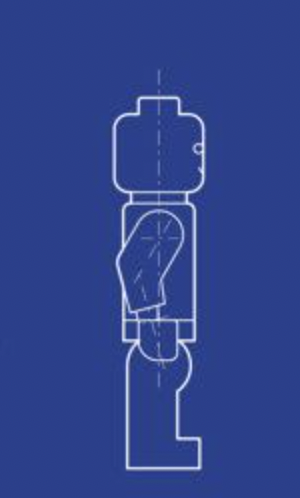

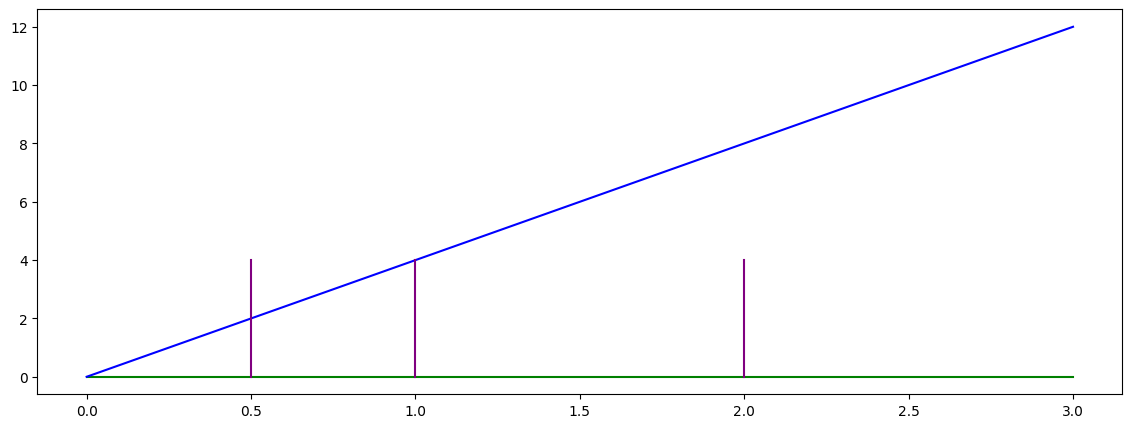

In [197]:
plt.plot([0, 3], [0, 0], 'green')  # ground
plt.plot([0, 3], [0, 12], 'blue')  # line of sight
plt.plot([1, 1], [0, 4], 'purple')  # minifig at z=1
plt.plot([2, 2], [0, 4], 'purple')  # minifig at z=2
plt.plot([0.5, 0.5], [0, 4], 'purple')  # minifig at z=0.5

Apparent height $y = h / z$

In [33]:
def perspective(vertices: np.ndarray) -> np.ndarray:
    z = vertices[:, 2][:, np.newaxis]  # all z-values
    return vertices[:, :2] / z  # pick x and y values and divide each row with the corresponding z-value

In [37]:
thetas = np.linspace(0, tau, 1024)
frames = [point_cloud_frame(
    transform(rotate_y(theta), vertices),
    project=perspective)
    for theta in thetas
]
display_gif(frames, framerate=1/25, width=512)

In [38]:
t = np.array([0, 0, 0.5])  # translation vector
thetas = np.linspace(0, tau, 1024)
frames = [point_cloud_frame(
    transform(rotate_y(theta), vertices) + t,
    project=perspective)
    for theta in thetas]
display_gif(frames, framerate=1/25, width=512)

## Triangles

[261  92 240]


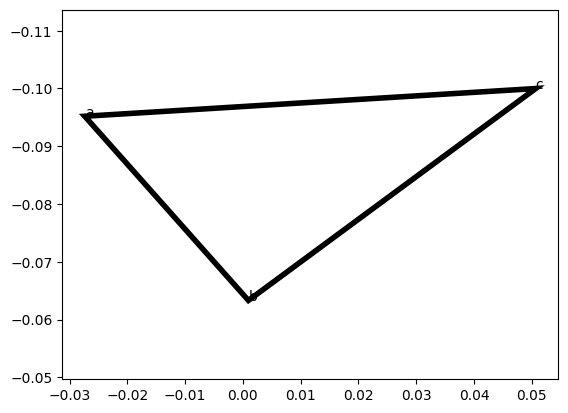

In [55]:
#triangle = (0, 1, 2)  # pick the first three vertices to work with
triangle = np.random.choice(len(vertices), size=3, replace=False)  # random triangle
print(triangle)
plt.fill(
    vertices[triangle, 0], vertices[triangle, 1],
    fill=False, lw=4)
a, b, c = vertices[triangle, :2]
plt.gca().annotate('a', a); plt.gca().annotate('b', b); plt.gca().annotate('c', c)
plt.axis('equal')
plt.gca().invert_yaxis()

## Barycentric cordinates

For each of the edges, e.g. $ab$ there is an _edge function_ 

$$E_{ab}(\boldsymbol{p}) = (\boldsymbol{b} - \boldsymbol{a}) \times (\boldsymbol{p} - \boldsymbol{a})$$

Similarly, there is an edge function for each of the three edges, $ab$, $bc$ and $ca$.

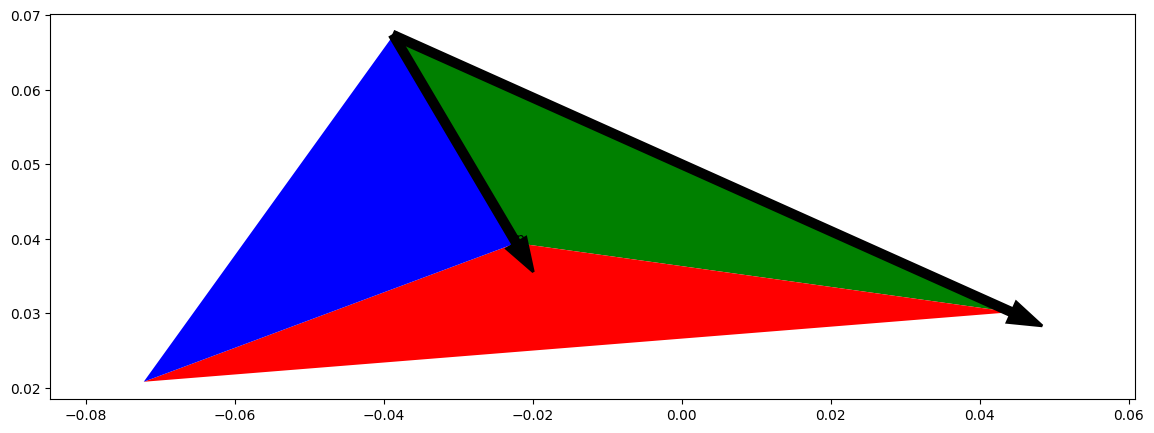

In [583]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 5]  # make plots larger

# let's use the midpoint as a point we know is inside the triangle
p = np.mean(vertices[triangle, :2], axis=0)

plt.axis('equal')
plt.gca().annotate('p', p)
plt.fill((a[0], p[0], b[0]), (a[1], p[1], b[1]), 'green')  # a,p,b
plt.fill((b[0], p[0], c[0]), (b[1], p[1], c[1]), 'red')    # b,p,c
plt.fill((c[0], p[0], a[0]), (c[1], p[1], a[1]), 'blue')   # c,p,a
plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1], lw=2, color='black')  # b - a
plt.arrow(a[0], a[1], p[0] - a[0], p[1] - a[1], lw=2, color='black')  # p - a

The signed area of the three sub-triangles sum to the total area.
$$A(abc) = A(apb) + A(bpc) + A(cpa)$$

We can use this to form a new set of cordinates for the point $\boldsymbol{p}$

$$\boldsymbol{p} = \frac{A(bpc)}{A(abc)}\boldsymbol{a} + \frac{A(cpa)}{A(abc)}\boldsymbol{b} + \frac{A(apb)}{A(abc)}\boldsymbol{c}$$

The cross product is the signed area of spanned by a parallellogram with the two vectors as sides.

$$A(apb) = 2E_{ab}(\boldsymbol{p})$$

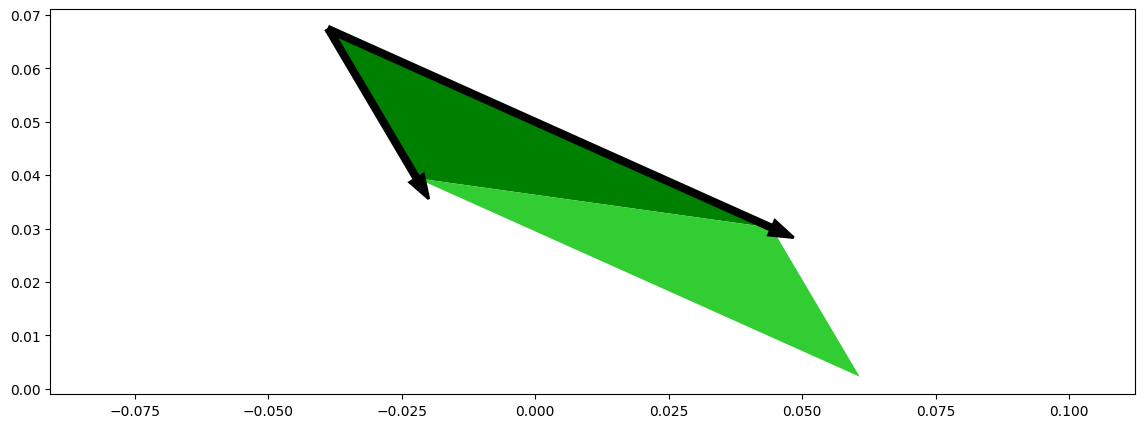

In [590]:
plt.axis('equal')
plt.fill((a[0], p[0], b[0]), (a[1], p[1], b[1]), 'green')  # a,p,b
tmp = a + (b - a) + (p - a)
plt.fill((p[0], b[0], tmp[0]), (p[1], b[1], tmp[1]), 'limegreen')  # a,p,b
plt.arrow(a[0], a[1], b[0] - a[0], b[1] - a[1], lw=2, color='black')  # b - a
plt.arrow(a[0], a[1], p[0] - a[0], p[1] - a[1], lw=2, color='black')  # p - a

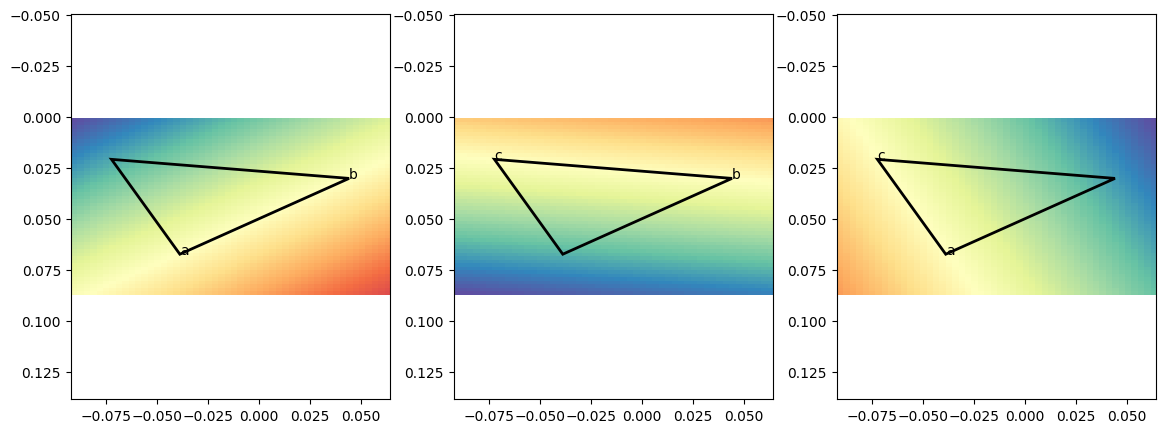

In [592]:
def edge(p0: np.ndarray, p1: np.ndarray, p: np.ndarray) -> float:
    """Computes the edge function at point p for the edge p0 -> p1. Arguments are either (1, 2) arrays or
    (n, 2) arrays. Broadcasting rules apply."""
    assert all(a.shape[1] == 2 for a in (p0, p1, p))  # all arrays must have two columns
    return (p[:, 0] - p0[:, 0]) * (p1[:, 1] - p0[:, 1])  - (p[:, 1] - p0[:, 1]) * (p1[:, 0] - p0[:, 0])

# get the three points of the triangle
a, b, c = np.vsplit(vertices[triangle, :2], 3)

# find the bounding box, with some padding
padding = 0.02
xmin, ymin, _ = np.min(vertices[triangle, :], axis=0) - padding
xmax, ymax, _ = np.max(vertices[triangle, :], axis=0) + padding

X, Y = np.meshgrid(np.linspace(xmin, xmax), np.linspace(ymin, ymax))  # arrange a gridspace on the bounding box
p = np.vstack([X.ravel(), Y.ravel()]).T  # arrange all the points of the grid as a list of points

from matplotlib import colormaps
def plot_edgefunction(ef: str, ax):
    v = max(-np.min(ef), np.max(ef))
    ax.axis('equal')
    ax.imshow(
        ef.reshape(X.shape),
        extent=(xmin, xmax, ymax, ymin),
        cmap=colormaps['Spectral'],  # divergent colormap to highlight the 0 line
        vmin=-v, vmax=v,  # center colormap on 0
    )
    # draw outline
    ax.fill(vertices[triangle, 0], vertices[triangle, 1], fill=False, lw=2)

def annotate(ax, labels):
    for text, position in labels.items():
        ax.annotate(text, position.ravel())

fig, axs = plt.subplots(1, 3)
plot_edgefunction(edge(a, b, p), axs[0]); annotate(axs[0], {'a': a, 'b': b})
plot_edgefunction(edge(b, c, p), axs[1]); annotate(axs[1], {'b': b, 'c': c})
plot_edgefunction(edge(c, a, p), axs[2]); annotate(axs[2], {'c': c, 'a': a})

* $E(\boldsymbol{p}) > 0$ if $p$ is inside the triangle
* $E(\boldsymbol{p}) = 0$ if $p$ is on the edge
* $E(\boldsymbol{p}) < 0$ if $p$ is outside the triangle

In [47]:
%load_ext Cython

In [48]:
%%cython
import cython
import numpy as np
cimport numpy as cnp

cdef const double edgef(
    const double p0x, const double p0y,
    const double p1x, const double p1y,
    const double x, const double y,
):
    return (x - p0x) * (p1y - p0y) - (y - p0y) * (p1x - p0x)


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def draw_triangle(
    cnp.ndarray[cnp.uint8_t, ndim=3] buffer: np.ndarray,
    cnp.ndarray[cnp.float64_t, ndim=2] corners: np.ndarray,
    colors,
):
    (ax, ay), (bx, by), (cx, cy) = corners  # unpack cordinates
    color_a, color_b, color_c = colors  # unpack colors

    # find the bounding box
    cdef int xmin, ymin, xmax, ymax
    xmin, ymin = np.min(corners, axis=0).astype(int)
    xmax, ymax = np.max(corners, axis=0).astype(int) + 1
    # clip
    xmin, xmax = max(xmin, 0), min(xmax, 320)
    ymin, ymax = max(ymin, 0), min(ymax, 200)
    
    cdef double area = edgef(ax, ay, bx, by, cx, cy)  # compute the (doubled) area

    cdef int x, y
    cdef double ab, bc, ca
    for y in range(ymin, ymax):
        for x in range(xmin, xmax):
            # compute edge functions
            ab = edgef(ax, ay, bx, by, x, y)
            bc = edgef(bx, by, cx, cy, x, y)
            ca = edgef(cx, cy, ax, ay, x, y)
            if ab >= 0 and bc >= 0 and ca >= 0:
                # compute the weights for the vertices
                aw, bw, cw = bc / area, ca / area, ab / area
                buffer[y, x] = aw * color_a + bw * color_b + cw * color_c

Content of stderr:
In file included from /Users/vidstige/.cache/ipython/cython/_cython_magic_9fe0070684e2cab743e29ea335113004a4803dd0.c:1204:
In file included from /Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.

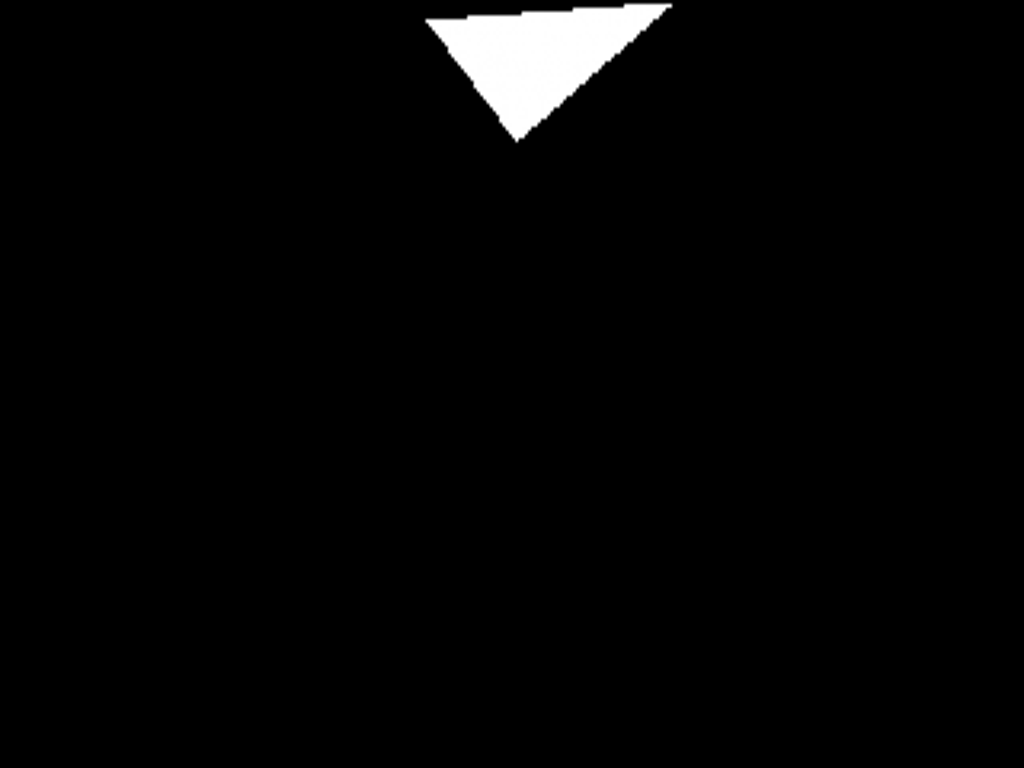

In [56]:
buffer = create_buffer(resolution)
screen = to_screen(5*vertices[triangle, :2], resolution)  # zoom in a bit
draw_triangle(buffer, screen, (0xff, 0xff, 0xff))
show_buffer(buffer)

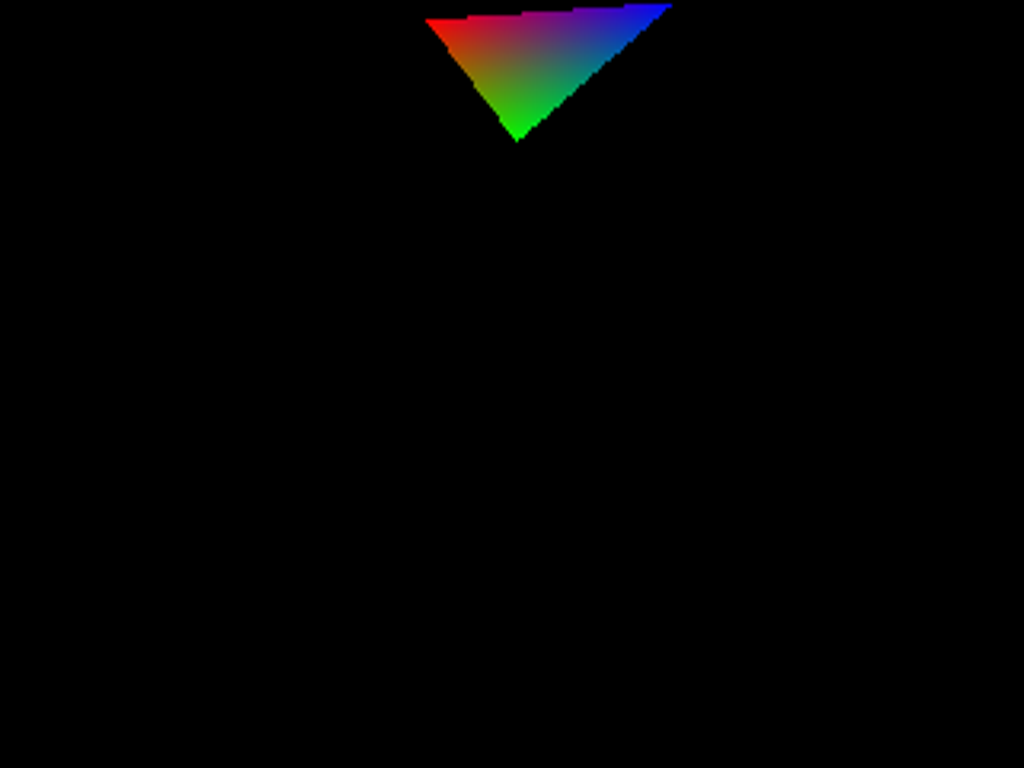

In [57]:
# test interpolation
buffer = create_buffer(resolution)
RED = (0xff, 0, 0)
GREEN = (0, 0xff, 0)
BLUE = (0, 0, 0xff)
draw_triangle(buffer, screen, np.array([RED, GREEN, BLUE]))
show_buffer(buffer)

# Mesh representation
Meshes, in its basic form, consists of a set of faces. For storage and manipulation vertices are normally _de-duplicated_, while for rendering vertices are normally _duplicated_ as it increase rendering speed.

In the de-duplicated format you have a _vertex list_ and a _face list_. Today only triangles are considered.

In [60]:
from typing import TextIO

def load_obj(f: TextIO) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Load object file and return mesh
    Args:
        f: open OBJ file to load.
    Returns:
        vertices: Mesh vertices.
        normals: Surface normals.
        faces: List of triangles.
    """
    vertices = []
    normals = []
    faces = []
    vertex_normals = []
    texture_coords = []
    for line in f:
        if line.startswith('#'):
            continue
        values = line.split()
        if not values:
            continue
        if values[0] == 'v':
            vertices.append(list(map(float, values[1:4])))
        elif values[0] == 'vn':
            normals.append(list(map(float, values[1:4])))
        elif values[0] == 'vt':
            continue
        elif values[0] == 'f':
            face_chunks = []
            for v in values[1:]:
                p = v.split('/')
                face_chunks.append(int(p[0]))
                # Format: v1/vt1
                if len(p) >= 2 and p[1]:
                    texture_coords.append(int(p[1]))
                # Format: v1/vt1/vn1 or v1//vn1
                if len(p) >= 3 and p[2]:
                    vertex_normals.append(int(p[2]))
            faces.append(face_chunks)

    # Return as numpy arrays and make faces 0-based, obj is 1-based.
    return np.asarray(vertices), np.asarray(faces, dtype=int) - 1, np.asarray(normals)

In [61]:
with open('left.obj') as f:  # samuels foot
    vertices, triangles, normals = load_obj(f)

print('vertices:', vertices.shape)
print(vertices)
print('triangles:', triangles.shape)
print(triangles)

vertices: (2553, 3)
[[-0.001952  0.014092  0.00027 ]
 [ 0.004665  0.014164  0.000039]
 [-0.006387  0.016252  0.000233]
 ...
 [ 0.001831  0.091643  0.14284 ]
 [ 0.001617  0.091654  0.14284 ]
 [ 0.031576  0.053052  0.14284 ]]
triangles: (5102, 3)
[[  84   26   88]
 [  29   90   88]
 [  26   29   88]
 ...
 [2498 2518 2489]
 [2489 2552 2462]
 [2489 2462 2498]]


In [62]:
# same code as before, just different vertices
t = np.array([0, -0.15, 0.4])
thetas = np.linspace(0, tau, 256)
frames = [point_cloud_frame(
    transform(rotate_y(theta), vertices) + t,
    project=perspective)
    for theta in thetas]
display_gif(frames, framerate=1/25, width=512)

In [63]:
# re-orient foot
vertices = transform(np.array([
    [1, 0, 0],   # for x, just keep the x
    [0, 0, -1],  # for y, take -z
    [0, 1, 0],   # for z, take y
]), vertices)
vertices = vertices - np.mean(vertices, axis=0)  # center mesh

In [64]:
t = np.array([0, 0.05, 0.4])
thetas = np.linspace(0, tau, 256)
frames = [point_cloud_frame(
    transform(rotate_y(theta), vertices) + t,
    project=perspective)
    for theta in thetas]
display_gif(frames, framerate=1/25, width=1024)

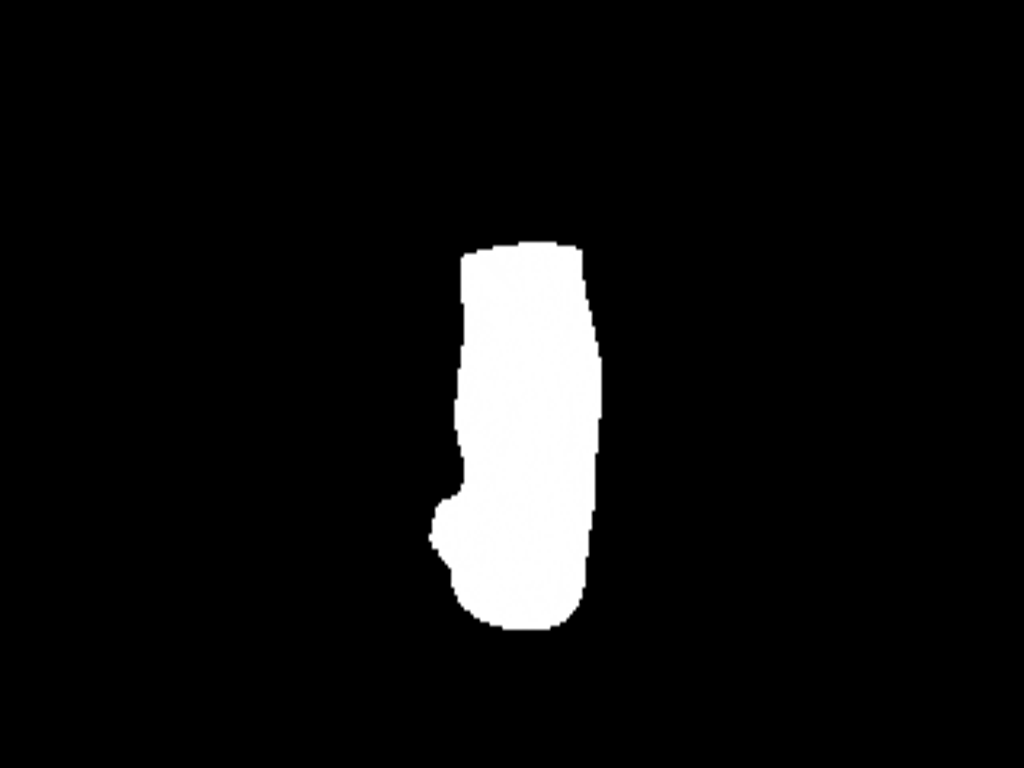

In [65]:
def draw_mesh(buffer: np.ndarray, vertices: np.ndarray, triangles: np.ndarray):
    screen = to_screen(perspective(vertices), resolution)
    for triangle in triangles:
        draw_triangle(buffer, screen[triangle], (0xff, 0xff, 0xff))

buffer = create_buffer(resolution)
draw_mesh(buffer, vertices + t, triangles)
show_buffer(buffer)

In [66]:
def draw_mesh(buffer, resolution, vertices, triangles):
    screen = to_screen(perspective(vertices), resolution)
    minz, maxz = np.min(vertices[:, 2]), np.max(vertices[:, 2])
    for triangle in triangles:
        mean_z = np.mean(vertices[triangle, 2], axis=0)
        intensity = 1.0 - (mean_z - minz) / (maxz - minz)
        colors = (int(255 * intensity), int(255 * intensity), int(255 * intensity))
        draw_triangle(buffer, screen[triangle], colors)

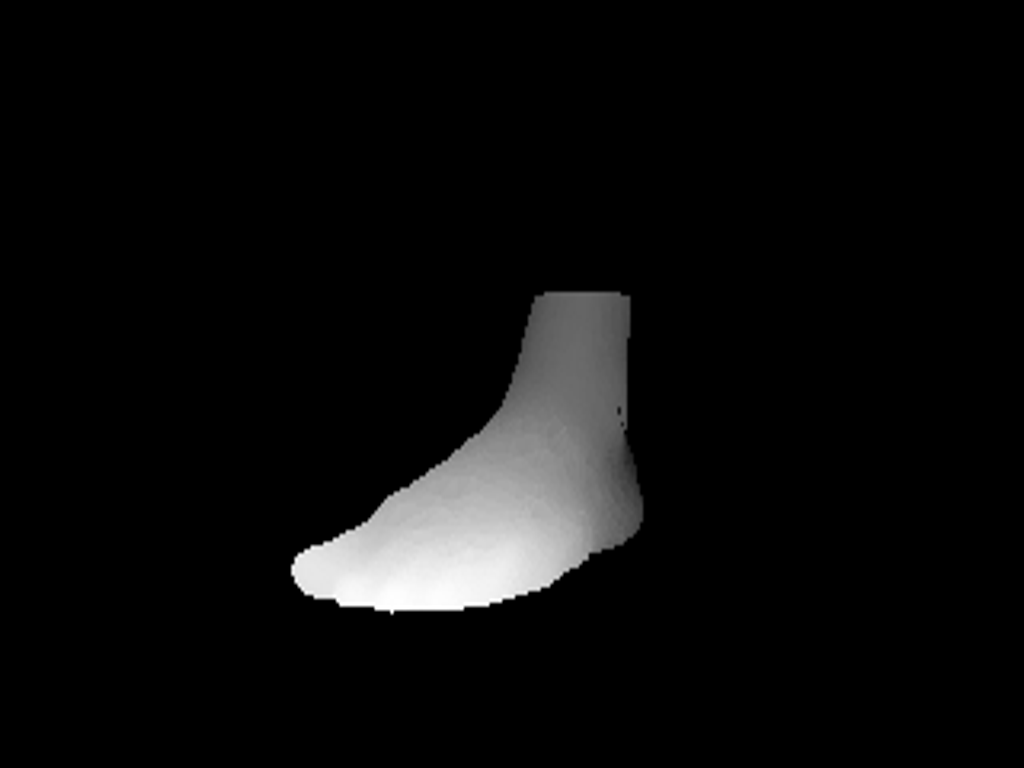

In [67]:
buffer = create_buffer(resolution)
draw_mesh(buffer, resolution, transform(rotate_y(theta=3/8*tau), vertices) + t, triangles)
show_buffer(buffer)

In [68]:
%%time
def mesh_frame(vertices, triangles):
    buffer = create_buffer(resolution)
    draw_mesh(buffer, resolution, vertices, triangles)
    return buffer

thetas = np.linspace(0, tau, 250)
frames = [mesh_frame(transform(rotate_y(theta), vertices) + t, triangles) for theta in thetas]
display_gif(frames, framerate=1/25, width=1024)

CPU times: user 14.6 s, sys: 84 ms, total: 14.7 s
Wall time: 14.8 s


## Z-buffering
For each pixel, keep track of the corresponding z-value of the pixel last painted there.

In [69]:
%%cython
import cython
import numpy as np
cimport numpy as cnp

cdef const double edgef(
    const double p0x, const double p0y,
    const double p1x, const double p1y,
    const double x, const double y,
):
    return (x - p0x) * (p1y - p0y) - (y - p0y) * (p1x - p0x)


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def draw_trianglez(
    cnp.ndarray[cnp.uint8_t, ndim=3] buffer: np.ndarray,
    cnp.ndarray[cnp.float64_t, ndim=2] zbuffer: np.ndarray,
    cnp.ndarray[cnp.float64_t, ndim=2] corners: np.ndarray,
    colors,
):
    (ax, ay, az), (bx, by, bz), (cx, cy, cz) = corners  # unpack cordinates
    color_a, color_b, color_c = colors  # unpack colors

    # find the bounding box
    cdef int xmin, ymin, xmax, ymax
    xmin, ymin, _ = np.min(corners, axis=0).astype(int)
    xmax, ymax, _ = np.max(corners, axis=0).astype(int) + 1
    # clip
    xmin, xmax = max(xmin, 0), min(xmax, 320)
    ymin, ymax = max(ymin, 0), min(ymax, 200)
    
    cdef double area = edgef(ax, ay, bx, by, cx, cy)  # compute the (doubled) area

    cdef int x, y
    cdef double ab, bc, ca
    cdef double z
    for y in range(ymin, ymax):
        for x in range(xmin, xmax):
            # compute edge functions
            ab = edgef(ax, ay, bx, by, x, y)
            bc = edgef(bx, by, cx, cy, x, y)
            ca = edgef(cx, cy, ax, ay, x, y)
            if ab >= 0 and bc >= 0 and ca >= 0:
                # compute the weights for the vertices
                aw, bw, cw = bc / area, ca / area, ab / area
                z = aw * az + bw * bz + cw * cz  # warning: z-incorrect interpolation
                if zbuffer[y, x] > z:
                    buffer[y, x] = aw * color_a + bw * color_b + cw * color_c
                    zbuffer[y, x] = z

Content of stderr:
In file included from /Users/vidstige/.cache/ipython/cython/_cython_magic_4a6b65360027a6004423dba4828589c7cf95d638.c:1205:
In file included from /Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/vidstige/src/cookie-talk-3d/venv/lib/python3.11/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.

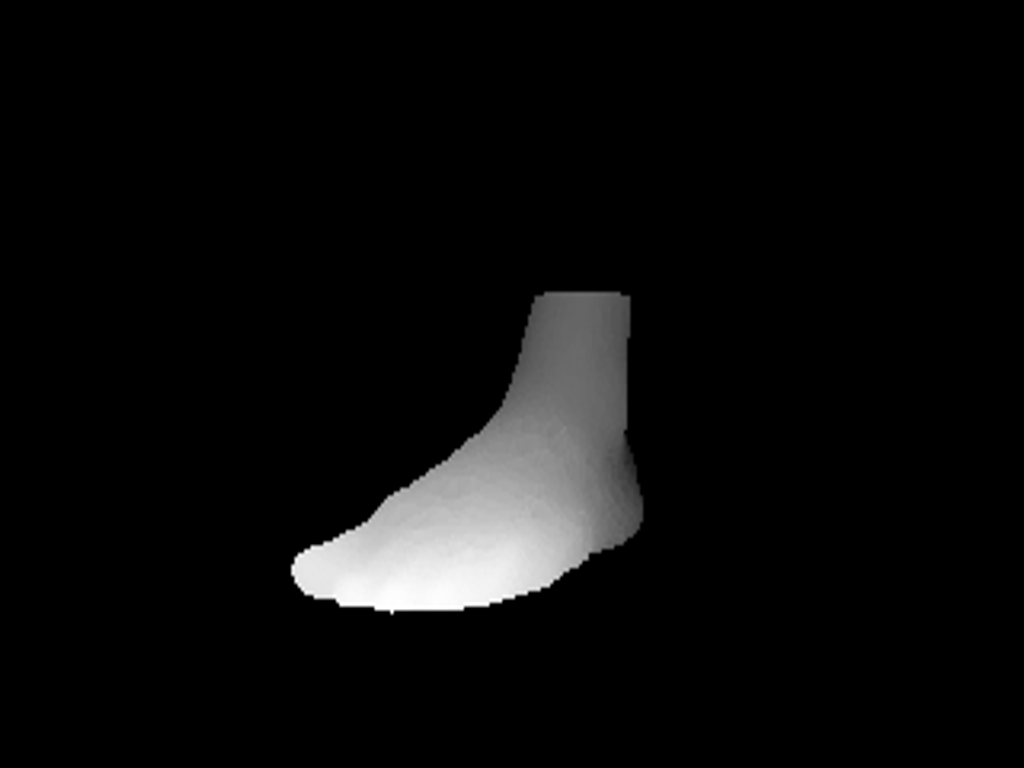

In [615]:
def draw_meshz(buffer, zbuffer, resolution, vertices, triangles):
    screen = to_screen(perspective(vertices), resolution)
    screenz = np.hstack((screen, vertices[:, 2][:, None]))
    minz, maxz = np.min(vertices[:, 2]), np.max(vertices[:, 2])
    for triangle in triangles:
        mean_z = np.mean(vertices[triangle, 2], axis=0)
        intensity = 1.0 - (mean_z - minz) / (maxz - minz)
        colors = (int(255 * intensity), int(255 * intensity), int(255 * intensity))
        draw_trianglez(buffer, zbuffer, screenz[triangle], colors)

buffer = create_buffer(resolution)
zbuffer = np.full((h, w), np.inf)
draw_meshz(buffer, zbuffer, resolution, transform(rotate_y(theta=3/8*tau), vertices) + t, triangles)
show_buffer(buffer)

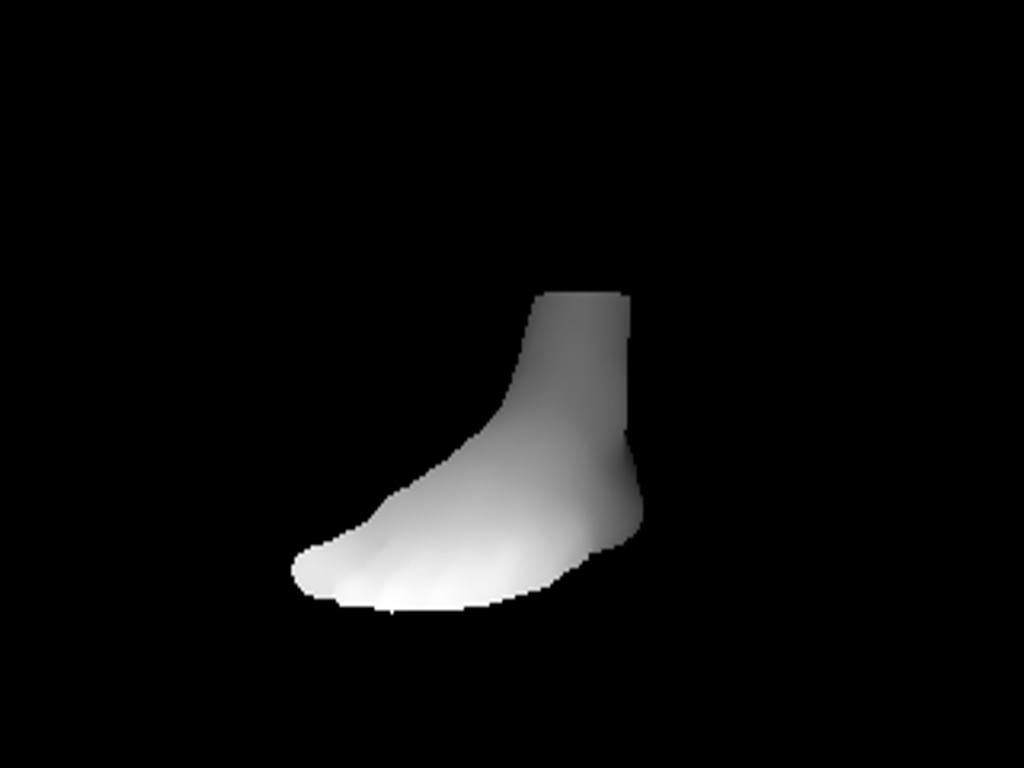

In [70]:
def draw_meshz(buffer, zbuffer, resolution, vertices, triangles):
    screen = to_screen(perspective(vertices), resolution)
    screenz = np.hstack((screen, vertices[:, 2][:, None]))
    minz, maxz = np.min(vertices[:, 2]), np.max(vertices[:, 2])
    for triangle in triangles:
        zs = vertices[triangle, 2]
        intensities = 1.0 - (zs - minz) / (maxz - minz)
        colors = tuple((255 * intensities).astype(np.uint8))
        draw_trianglez(buffer, zbuffer, screenz[triangle], colors)

buffer, zbuffer = create_buffer(resolution), np.full((h, w), np.inf)
draw_meshz(buffer, zbuffer, resolution, transform(rotate_y(theta=3/8*tau), vertices) + t, triangles)
show_buffer(buffer)

In [613]:
%%time
def mesh_frame(vertices, triangles):
    buffer = create_buffer(resolution)
    zbuffer = np.full((h, w), np.inf)
    draw_meshz(buffer, zbuffer, resolution, vertices, triangles)
    return buffer

thetas = np.linspace(0, tau, 250)
frames = [mesh_frame(transform(rotate_y(theta), vertices) + t, triangles) for theta in thetas]
display_gif(frames, framerate=1/25, width=1024)

CPU times: user 18.3 s, sys: 86 ms, total: 18.4 s
Wall time: 18.4 s


# Questions?

## Quizz time!
The edge function...
* Computes a function at the compute edge, similar to a cloud function
* Is one permutation of the three edges of the triangle
* Computes the signed distance to the line of an edge

A mesh...
* Contains negative values inside the surface and positive values outside
* Consists of a set of vertices and faces
* Is a type of error handling for C++

Z-buffering
* Caches the z-values for faster vertex transformations
* Keeps track of the corresponding z-value of a painted pixel
* Buffers all zero pixels (black) before rendering

Some C-code https://github.com/vidstige/mini3d/

# Thank you!